In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [23]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:1+i for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}

In [125]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next?
X,Y = [],[] # X input to nn, Y labels
for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # for crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [127]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [167]:
C = torch.randn((27,2)) # we have 27 letters, and give each a 2-dimensional embedding
# first layer
W1 = torch.randn((6,100)) # input: 3 "words" x vector embedding size 2 = 6, output: 100 neurons
b1 = torch.randn(100) # biases for 100 neurons
# second layer
W2 = torch.randn((100,27)) # input: 100 neurons, output: 27 neurons (one for each character)
b2 = torch.randn(27) # our biases
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # total number of parameters

3481

In [168]:
for p in parameters:
    p.requires_grad = True

Note: We batch because it is much more valuable to approximate the gradient and take more steps than it is to calculate the exact gradient and take fewer steps.

Question: How to optimize our learning rate?

In [169]:
# we estimate our best learning rate is somewhere between -0.001 and -1
# it doesn't make sense to step through them linearily, so we take the exponent to be spaced exponentially
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs[:10]

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011])

In [183]:
batch_size = 32
lri = []
lossi = []
for i in range(10000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (batch_size,))

    # forward pass
    emb = C[X[ix]] # embeddings 32x3x2
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    loss = F.cross_entropy(logits, Y[ix]) # far more efficient than implementation shown below

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    # here is our good learning rate, also we decay it after a while
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
    
    # # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

# this is actually only evaluating the loss on the mini-batch
# print(loss.item())


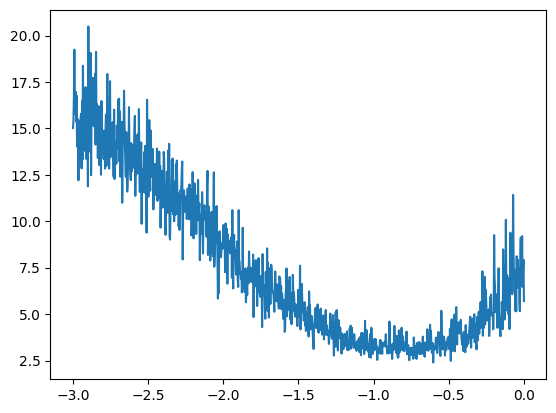

In [172]:
# here is the exponent of the learning rate... we see 10^-1 = 0.1 is probably our best bet
plt.plot(lri, lossi)

In [184]:
emb = C[X[ix]] # embeddings 32x3x2
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # 32x100
logits = h @ W2 + b2 # 32x27

# below is full implementation for finding loss
# counts = logits.exp() # get our "fake" counts, ie smoothing
# prob = counts/counts.sum(1, keepdims=True) # normalize into a probability function
# loss = -prob[torch.arange(32), Y].log().mean() # negative log likelihood loss function

loss = F.cross_entropy(logits, Y[ix])
print(loss.item())

2.147106647491455


Using train/dev/test splits

In [ ]:
# training split, validation/dev split, test split
# ~80%, ~10%, ~10%
# train: used to train your parameters, validation: used to train hyperparameters, test: used to test your final model

In [201]:
# build the dataset 

def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [211]:
Xtr.shape, Ytr.shape # training dataset

(torch.Size([182424, 3]), torch.Size([182424]))

In [203]:
C = torch.randn((27,2)) # we have 27 letters, and give each a 2-dimensional embedding
# first layer
W1 = torch.randn((6,100)) # input: 3 "words" x vector embedding size 2 = 6, output: 100 neurons
b1 = torch.randn(100) # biases for 100 neurons
# second layer
W2 = torch.randn((100,27)) # input: 100 neurons, output: 27 neurons (one for each character)
b2 = torch.randn(27) # our biases
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters) # total number of parameters

3481

In [204]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs[:10]

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011])

In [205]:
batch_size = 32
lri = []
lossi = []
for i in range(30000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix]) 

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
    
    # # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
        
# print(loss.item())

2.4376862049102783


Note: when our training set loss ~ dev set loss => we are underfitting.

Underfitting typically means our network is tiny, and we expect to make performance improvements by scaling up the size of the neural net.

In [209]:
# evaluating the training set loss
emb = C[Xtr] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.4624574184417725


In [210]:
# evaluating the dev loss
emb = C[Xdev] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.4690237045288086


Changing the neural net size

In [216]:
C = torch.randn((27,2))

W1 = torch.randn((6,300)) # changed to 300 neurons
b1 = torch.randn(300) 

W2 = torch.randn((300,27)) 
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters) # total number of parameters

10281

In [224]:
batch_size = 32
lri = []
lossi = []
stepi = []

for i in range(60000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix]) 

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepi.append(i)
    lossi.append(loss.item())
        
# print(loss.item())

In [225]:
# evaluating the training set loss
emb = C[Xtr] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.443328380584717


In [226]:
# evaluating the dev loss
emb = C[Xdev] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.4569897651672363


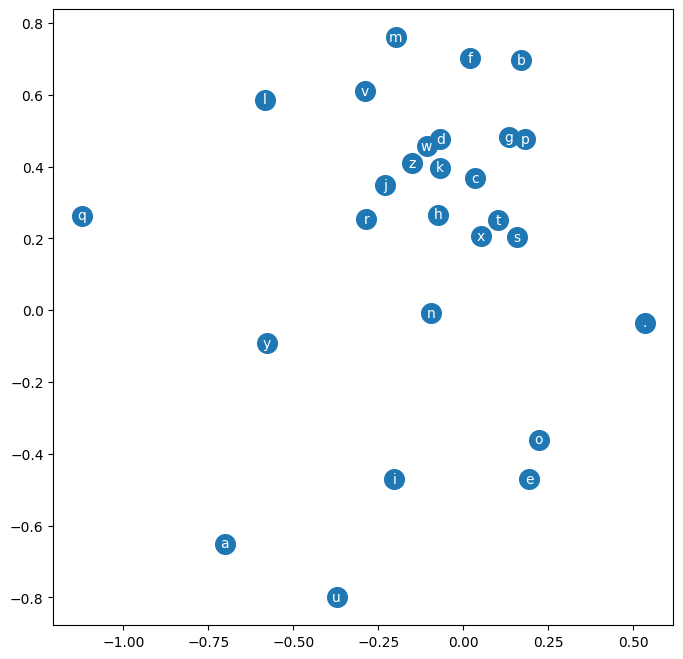

In [227]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')

Now, we will scale up the embedding dimension from 2. This will make it impossible to visualize, but we know now that this embedding dimension is likely the constraint we need to fix.

In [242]:
C = torch.randn((27,10)) # each letter has a vector embedding of size 10 now

W1 = torch.randn((30,200)) # (3 ch window * vector len=10 = 30 input) also we decreased to 200 neurons
b1 = torch.randn(200) 

W2 = torch.randn((200,27)) 
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters) # total number of parameters

11897

In [243]:
lri = []
lossi = []
stepi = []
batch_size = 32

In [244]:
for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix]) 

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item()) # changed to log10
        
# print(loss.item())

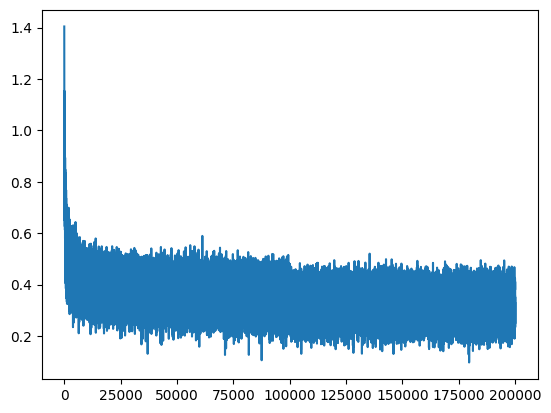

In [245]:
plt.plot(stepi,lossi)

In [246]:
# evaluating the training set loss
emb = C[Xtr] 
h = torch.tanh(emb.view(-1,30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.1206376552581787


In [247]:
# evaluating the dev loss
emb = C[Xdev] 
h = torch.tanh(emb.view(-1,30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.179995059967041


In [249]:
# evaluating the test loss
emb = C[Xte] 
h = torch.tanh(emb.view(-1,30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yte)
print(loss.item())

2.1781182289123535


In [248]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        enb = C[torch.tensor([context])]
        h = torch.tanh(enb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

jahuri.
vaigh.
zeal.
maddera.
anusty.
anna.
eadaurtee.
alyn.
arie.
bri.
trevernesssolynn.
ana.
alirien.
yannan.
cono.
dema.
karin.
alvine.
doordaya.
cada.
